# CS252A Project
## Phase 2
### Authors: Ahmad Mersaghian and Demetreous Stillman

In [22]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from folium.plugins import HeatMap
import folium
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import make_scorer, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Load Data
accidents = pd.read_csv("Accidents0514.csv", low_memory=False)
casualties = pd.read_csv("Casualties0514.csv")
vehicles = pd.read_csv("Vehicles0514.csv")

# Store metadata for each sheet into dictionary
xls = pd.ExcelFile("Road-Accident-Safety-Data-Guide.xls")
sheets = xls.sheet_names
metadata = {}
for sheet in sheets:
    metadata[sheet] = pd.read_excel(xls, sheet_name=sheet)

In [3]:
# Set pandas to display all rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all column

In [4]:
accidents.head()

Accident_Index  Location_Easting_OSGR  Location_Northing_OSGR  Longitude  \
0  200501BS00001               525680.0                178240.0  -0.191170   
1  200501BS00002               524170.0                181650.0  -0.211708   
2  200501BS00003               524520.0                182240.0  -0.206458   
3  200501BS00004               526900.0                177530.0  -0.173862   
4  200501BS00005               528060.0                179040.0  -0.156618   

    Latitude  Police_Force  Accident_Severity  Number_of_Vehicles  \
0  51.489096             1                  2                   1   
1  51.520075             1                  3                   1   
2  51.525301             1                  3                   2   
3  51.482442             1                  3                   1   
4  51.495752             1                  3                   1   

   Number_of_Casualties        Date  Day_of_Week   Time  \
0                     1  04/01/2005            3  17:42   
1                     1  05/01/2005            4  17:36   
2                     1  06/01/2005            5  00:15   
3                     1  07/01/2005            6  10:35   
4                     1  10/01/2005            2  21:13   

   Local_Authority_(District) Local_Authority_(Highway)  1st_Road_Class  \
0                          12                 E09000020               3   
1                          12                 E09000020               4   
2                          12                 E09000020               5   
3                          12                 E09000020               3   
4                          12                 E09000020               6   

   1st_Road_Number  Road_Type  Speed_limit  Junction_Detail  Junction_Control  \
0             3218          6           30                0                -1   
1              450          3           30                6                 2   
2                0          6           30                0                -1   
3             3220          6           30                0                -1   
4                0          6           30                0                -1   

   2nd_Road_Class  2nd_Road_Number  Pedestrian_Crossing-Human_Control  \
0              -1                0                                  0   
1               5                0                                  0   
2              -1                0                                  0   
3              -1                0                                  0   
4              -1                0                                  0   

   Pedestrian_Crossing-Physical_Facilities  Light_Conditions  \
0                                        1                 1   
1                                        5                 4   
2                                        0                 4   
3                                        0                 1   
4                                        0                 7   

   Weather_Conditions  Road_Surface_Conditions  Special_Conditions_at_Site  \
0                   2                        2                           0   
1                   1                        1                           0   
2                   1                        1                           0   
3                   1                        1                           0   
4                   1                        2                           0   

   Carriageway_Hazards  Urban_or_Rural_Area  \
0                    0                    1   
1                    0                    1   
2                    0                    1   
3                    0                    1   
4                    0                    1   

   Did_Police_Officer_Attend_Scene_of_Accident LSOA_of_Accident_Location  
0                                            1                 E01002849  
1                                            1                 E01002909  
2                       

In [241]:
# Calculate the number of NaN values in each column of accidents table
count_na = accidents.isna().sum()
print(count_na)

Accident_Index                                      0
Location_Easting_OSGR                             111
Location_Northing_OSGR                            111
Longitude                                         111
Latitude                                          111
Police_Force                                        0
Accident_Severity                                   0
Number_of_Vehicles                                  0
Number_of_Casualties                                0
Date                                                0
Day_of_Week                                         0
Time                                              133
Local_Authority_(District)                          0
Local_Authority_(Highway)                           0
1st_Road_Class                                      0
1st_Road_Number                                     0
Road_Type                                           0
Speed_limit                                         0
Junction_Detail             

In [5]:
# Output the count of rows where all these columns have NaN values
na_rows_count = (accidents['Location_Easting_OSGR'].isna() & accidents['Location_Northing_OSGR'].isna() & accidents['Longitude'].isna() & accidents['Latitude'].isna()).sum()
na_rows_count

111

### Data cleaning

- Dropping LSOA_of_Accident_Location because the are district code names that do not make sense in our case because we have the precise coordinates for accidents.
- Also Dropping Location_Easting_OSGR and Location_Northing_OSGR for Longitude and Latitude because they are representing the same thing (The line above is a sanity check that what we are doing is right).
- Finally dropping na rows in longitude, latitude, and time because there are very few missing and dropping them does not substantially effect our results.
- We are dropping "Local_Authority_(District)", "Local_Authority_(Highway)", "Police_Force" because they are irrelevant to our analysis (just show the authority in the area where the accident happend).


In [6]:
# Drop irrelevant attributes and remove nulls
accidents.drop('LSOA_of_Accident_Location', axis=1, inplace=True)
accidents.drop('Location_Easting_OSGR', axis=1, inplace=True)
accidents.drop('Location_Northing_OSGR', axis=1, inplace=True)
accidents.drop('Local_Authority_(District)', axis=1, inplace=True)
accidents.drop('Local_Authority_(Highway)', axis=1, inplace=True)
accidents.drop('Police_Force', axis=1, inplace=True)
accidents.dropna(subset=['Longitude', 'Latitude', 'Time'], inplace=True)
casualties.drop('Age_Band_of_Casualty', axis=1, inplace=True)
casualties.drop('Casualty_Home_Area_Type', axis=1, inplace=True)
vehicles.drop('Driver_Home_Area_Type', axis=1, inplace=True)
vehicles.drop('Age_Band_of_Driver', axis=1, inplace=True)
vehicles.drop('Driver_IMD_Decile', axis=1, inplace=True)
vehicles = vehicles[vehicles['Sex_of_Driver'] != -1]

### Now we don't have any missing values in our dataframes ;)

- We then only have to keep rows in causalties and vehicles where there is a corresponding `Accident_Index` in accident dataframe. This is because we dropped some of the rows in accidents so casualties and vehicles have to match that as well.

In [7]:
# Remove Rows that no longer corresponf to the accident table
casualties = casualties[casualties['Accident_Index'].isin(accidents['Accident_Index'])]
vehicles = vehicles[vehicles['Accident_Index'].isin(accidents['Accident_Index'])]

### Here we examine the columns in our datasets

In [8]:
accidents.columns

Index(['Accident_Index', 'Longitude', 'Latitude', 'Accident_Severity',
       'Number_of_Vehicles', 'Number_of_Casualties', 'Date', 'Day_of_Week',
       'Time', '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit',
       'Junction_Detail', 'Junction_Control', '2nd_Road_Class',
       '2nd_Road_Number', 'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident'],
      dtype='object')

In [9]:
casualties.columns

Index(['Accident_Index', 'Vehicle_Reference', 'Casualty_Reference',
       'Casualty_Class', 'Sex_of_Casualty', 'Age_of_Casualty',
       'Casualty_Severity', 'Pedestrian_Location', 'Pedestrian_Movement',
       'Car_Passenger', 'Bus_or_Coach_Passenger',
       'Pedestrian_Road_Maintenance_Worker', 'Casualty_Type'],
      dtype='object')

In [10]:
vehicles.columns

Index(['Accident_Index', 'Vehicle_Reference', 'Vehicle_Type',
       'Towing_and_Articulation', 'Vehicle_Manoeuvre',
       'Vehicle_Location-Restricted_Lane', 'Junction_Location',
       'Skidding_and_Overturning', 'Hit_Object_in_Carriageway',
       'Vehicle_Leaving_Carriageway', 'Hit_Object_off_Carriageway',
       '1st_Point_of_Impact', 'Was_Vehicle_Left_Hand_Drive?',
       'Journey_Purpose_of_Driver', 'Sex_of_Driver', 'Age_of_Driver',
       'Engine_Capacity_(CC)', 'Propulsion_Code', 'Age_of_Vehicle'],
      dtype='object')

In [11]:
police_presence = pd.Series(metadata['Police Officer Attend']['label'].values, index = metadata['Police Officer Attend']['code']).to_dict()
accidents['Did_Police_Officer_Attend_Scene_of_Accident'] = accidents['Did_Police_Officer_Attend_Scene_of_Accident'].map(police_presence)

In [12]:
accidents['Did_Police_Officer_Attend_Scene_of_Accident'].value_counts()

Did_Police_Officer_Attend_Scene_of_Accident
Yes                                                                         1326093
No                                                                           310825
No - accident was reported using a self completion  form (self rep only)       3166
Name: count, dtype: int64

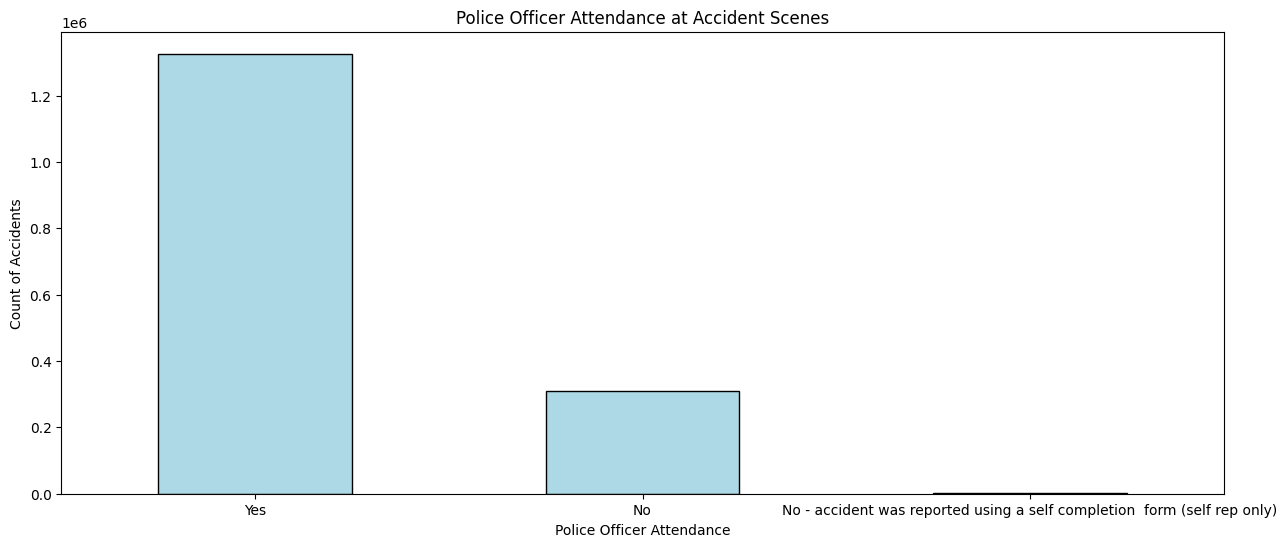

In [250]:
# Plotting police attendance counts at accident
attendance_counts = accidents['Did_Police_Officer_Attend_Scene_of_Accident'].value_counts()

plt.figure(figsize=(15, 6))
attendance_counts.plot(kind='bar', color = 'lightblue', edgecolor = 'black')
plt.title('Police Officer Attendance at Accident Scenes')
plt.xlabel('Police Officer Attendance')
plt.ylabel('Count of Accidents')
plt.xticks(rotation=0)
plt.show()

In [251]:
police_presence = pd.Series(metadata['Accident Severity']['label'].values, index=metadata['Accident Severity']['code']).to_dict()
accidents['Accident_Severity'] = accidents['Accident_Severity'].map(police_presence)

In [252]:
accidents['Accident_Severity'].value_counts()

Accident_Severity
Slight     1396972
Serious     222000
Fatal        21381
Name: count, dtype: int64

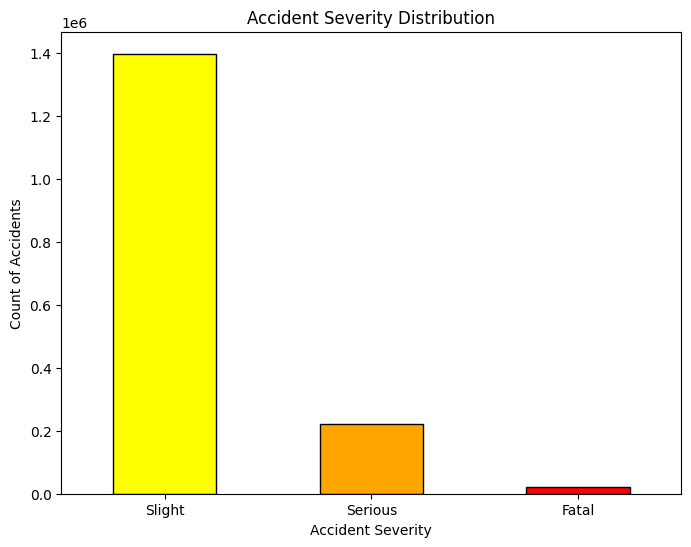

In [253]:
# Plotting accident severity counts
severity_counts = accidents['Accident_Severity'].value_counts()

plt.figure(figsize=(8, 6))
colors = {'Slight': 'yellow', 'Serious': 'orange', 'Fatal': 'red'}
severity_counts.plot(kind='bar', color=[colors.get(severity, 'gray') for severity in severity_counts.index], edgecolor = 'black')
plt.title('Accident Severity Distribution')
plt.xlabel('Accident Severity')
plt.ylabel('Count of Accidents')
plt.xticks(rotation=0)
plt.show()

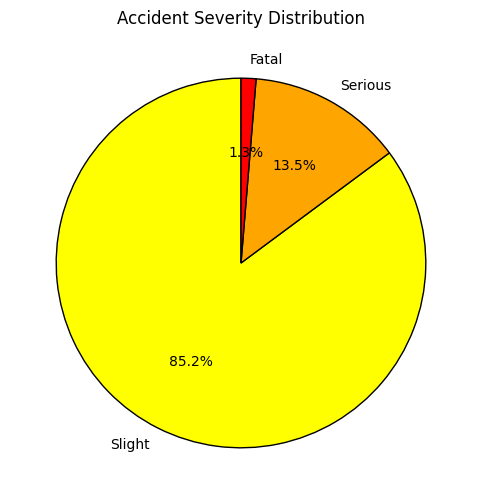

In [254]:
# Plotting accident severity pie chart
severity_counts = accidents['Accident_Severity'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 6))
colors = {'Slight': 'yellow', 'Serious': 'orange', 'Fatal': 'red'}
severity_counts.plot(kind='pie', colors=[colors.get(severity, 'gray') for severity in severity_counts.index],
                     autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
plt.title('Accident Severity Distribution')
plt.ylabel('')
plt.show()

In [255]:
accidents['Date'] = pd.to_datetime(accidents['Date'], format="%d/%m/%Y")
accidents['Year'] = accidents['Date'].dt.year

Text(0, 0.5, 'Number of Accidents')

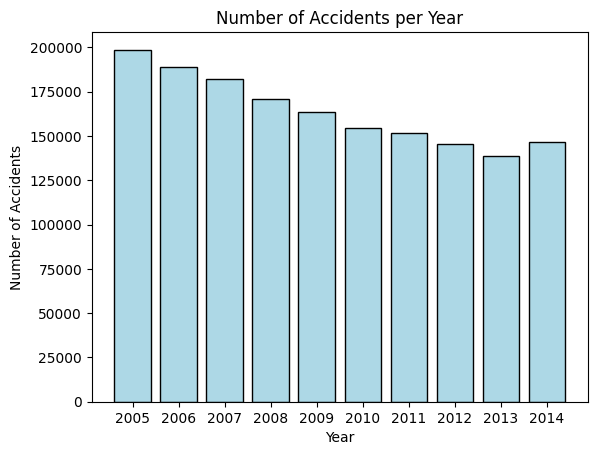

In [256]:
count_by_year = accidents.groupby('Year').size().reset_index(name='Number_of_Accidents')
plt.bar(count_by_year['Year'], count_by_year['Number_of_Accidents'], color='lightblue', edgecolor = 'black')
plt.title('Number of Accidents per Year')
plt.xlabel('Year')
plt.xticks(count_by_year['Year'])
plt.ylabel('Number of Accidents')

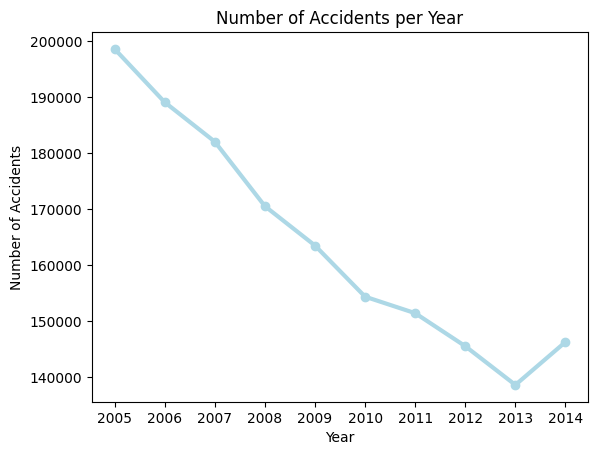

In [257]:
# Plot a line chart
plt.plot(count_by_year['Year'], count_by_year['Number_of_Accidents'], marker='o', color='lightblue', linestyle='-', linewidth=3)
plt.xlabel('Year')
plt.title('Number of Accidents per Year')
plt.xticks(count_by_year['Year'])
plt.ylabel('Number of Accidents')
plt.show()

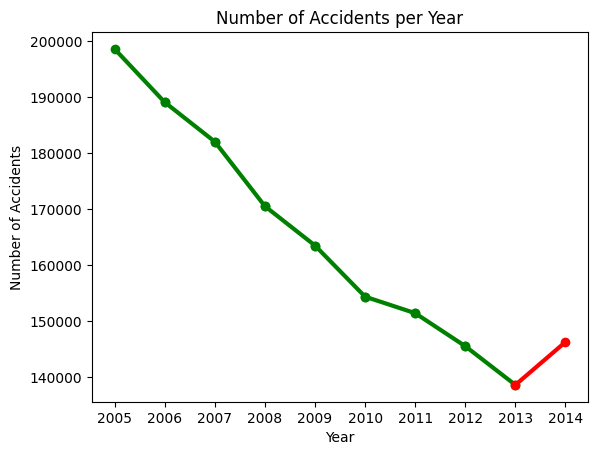

In [212]:
# Loop through the years and plot each segment
for i in range(len(count_by_year) - 1):
    # Determine the color based on the trend
    if count_by_year['Number_of_Accidents'].iloc[i + 1] > count_by_year['Number_of_Accidents'].iloc[i]:
        color = 'red'  # Increasing trend
    else:
        color = 'green'  # Decreasing trend
    
    # Plot the segment
    plt.plot(
        count_by_year['Year'].iloc[i:i + 2], 
        count_by_year['Number_of_Accidents'].iloc[i:i + 2], 
        marker='o', color=color, linestyle='-', linewidth=3
    )

# Add labels and title
plt.xlabel('Year')
plt.title('Number of Accidents per Year')
plt.xticks(count_by_year['Year'])
plt.ylabel('Number of Accidents')

# Show the plot
plt.show()


In [258]:
weekday = pd.Series(metadata['Day of Week']['label'].values, index=metadata['Day of Week']['code']).to_dict()
accidents['Day_of_Week'] = accidents['Day_of_Week'].map(weekday)

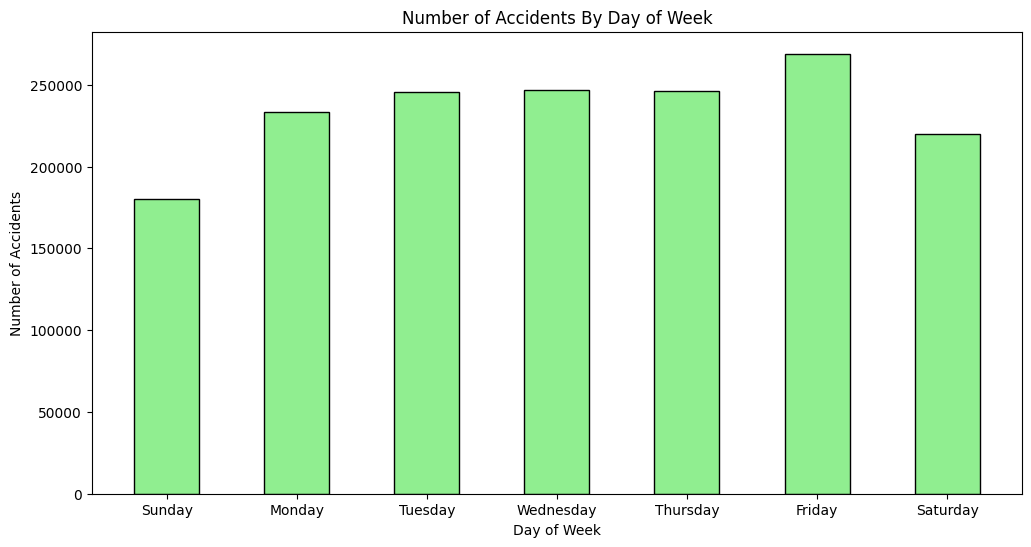

In [268]:
# Day order for chart
day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
accidents['Day_of_Week'] = pd.Categorical(accidents['Day_of_Week'], categories = day_order, ordered=True)
# Group by 'Day_of_Week' and calculate the count per day
count_by_week = accidents.groupby('Day_of_Week', observed=False).size().reset_index(name='Number_of_Accidents_per_week')
# Sort by the categorical order to ensure correct plotting order
count_by_week = count_by_week.sort_values(by='Day_of_Week')

# Plot the bar chart
plt.figure(figsize=(12, 6)) 
plt.bar(count_by_week['Day_of_Week'], count_by_week['Number_of_Accidents_per_week'], width=0.5, color='lightgreen', edgecolor='black')
plt.title('Number of Accidents By Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Accidents')
plt.show()

In [260]:
sex = pd.Series(metadata['Sex of Driver']['label'].values, index=metadata['Sex of Driver']['code']).to_dict()
vehicles['Sex_of_Driver'] = vehicles['Sex_of_Driver'].map(sex)

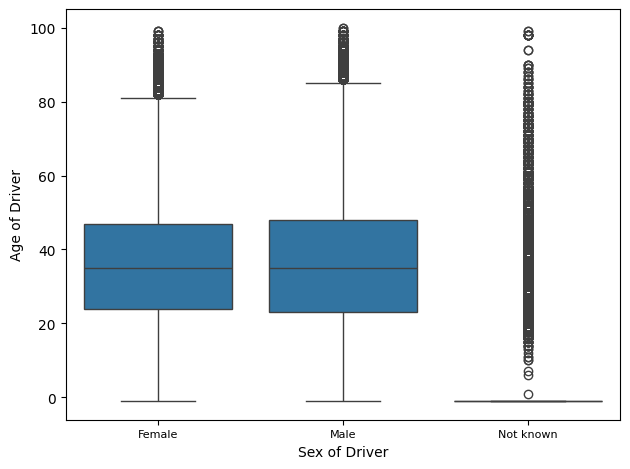

In [261]:
sns.boxplot(x='Sex_of_Driver', y='Age_of_Driver', data=vehicles)
plt.xticks(rotation=0, ha='center', fontsize=8, rotation_mode='anchor')
plt.xlabel('Sex of Driver')
plt.ylabel('Age of Driver')
plt.tight_layout()

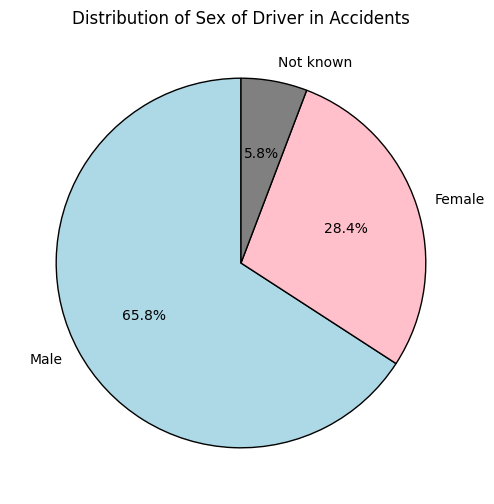

In [262]:
# Count the occurrences of each category in 'Sex_of_Driver'
sex_counts = vehicles['Sex_of_Driver'].value_counts()

# Define custom colors for each category
color_mapping = {'Male': 'lightblue', 'Female': 'pink', 'Not known': 'gray'}
selected_colors = [color_mapping[label] for label in sex_counts.index]

# Plot the pie chart
plt.figure(figsize=(6, 6))
plt.pie(sex_counts, labels=sex_counts.index, colors=selected_colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
plt.title('Distribution of Sex of Driver in Accidents')
plt.show()

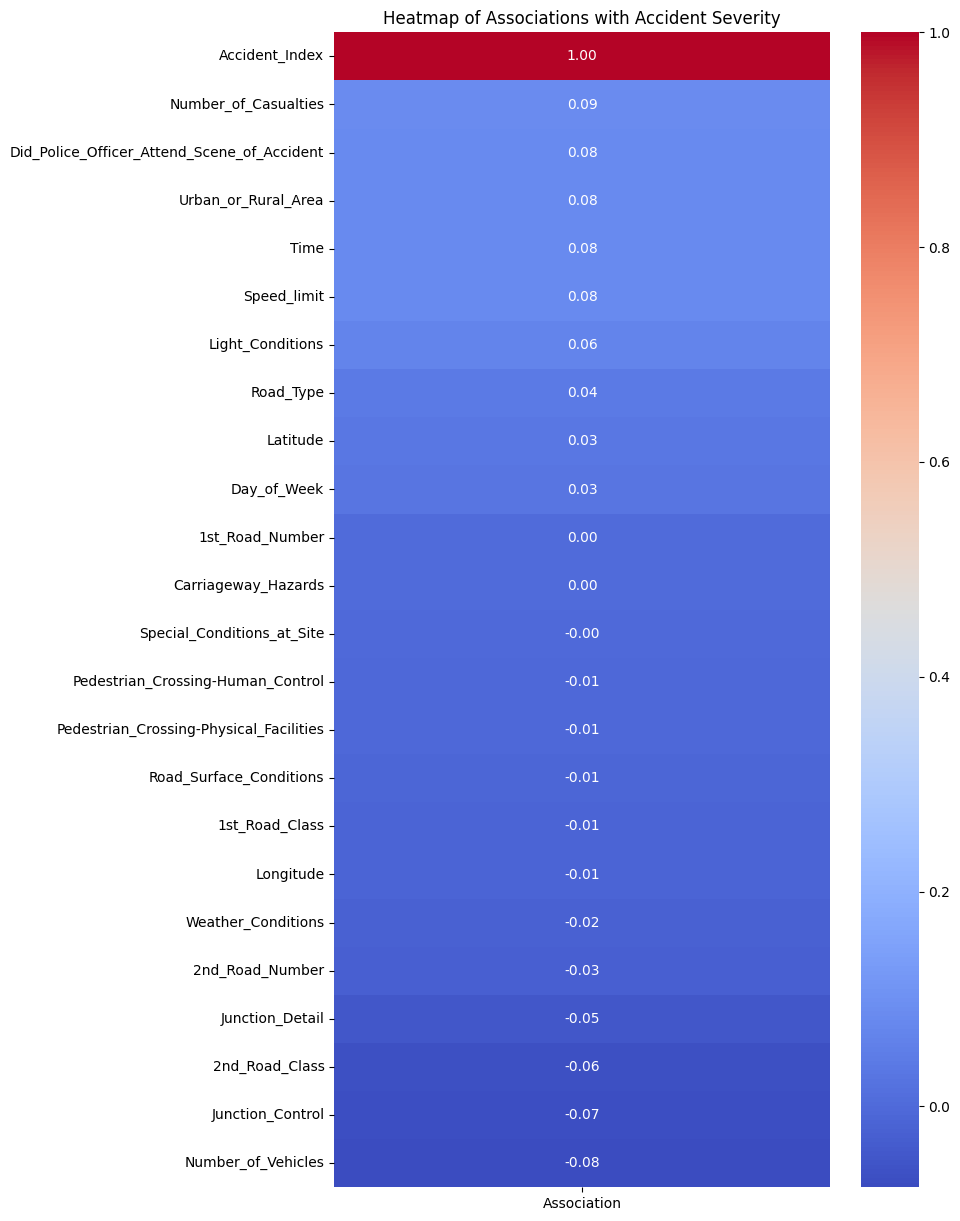

In [ ]:
# Heat Map of features correlation to accident severity

# Function to compute Cramér's V for categorical features
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))


df = accidents

# Map Accident_Severity to ordinal values
severity_mapping = {'Slight': 0, 'Serious': 1, 'Fatal': 2}
df['Accident_Severity_Encoded'] = df['Accident_Severity'].map(severity_mapping)

# Identify numeric and categorical features
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object', 'category']).columns

# Initialize a dictionary to hold associations
associations = {}

# Calculate correlations for numeric features
for feature in numeric_features:
    if feature != 'Accident_Severity_Encoded':
        associations[feature] = df['Accident_Severity_Encoded'].corr(df[feature])

# Calculate Cramér's V for categorical features
for feature in categorical_features:
    if feature != 'Accident_Severity':
        associations[feature] = cramers_v(df['Accident_Severity'], df[feature])

# Create a DataFrame for the heatmap
associations_df = pd.DataFrame.from_dict(associations, orient='index', columns=['Association']).sort_values(by='Association', ascending=False)

# Plot the heatmap
plt.figure(figsize=(8, 15))
sns.heatmap(associations_df, annot=True, cmap='coolwarm', cbar=True, fmt=".2f")
plt.title('Heatmap of Associations with Accident Severity')
plt.show()

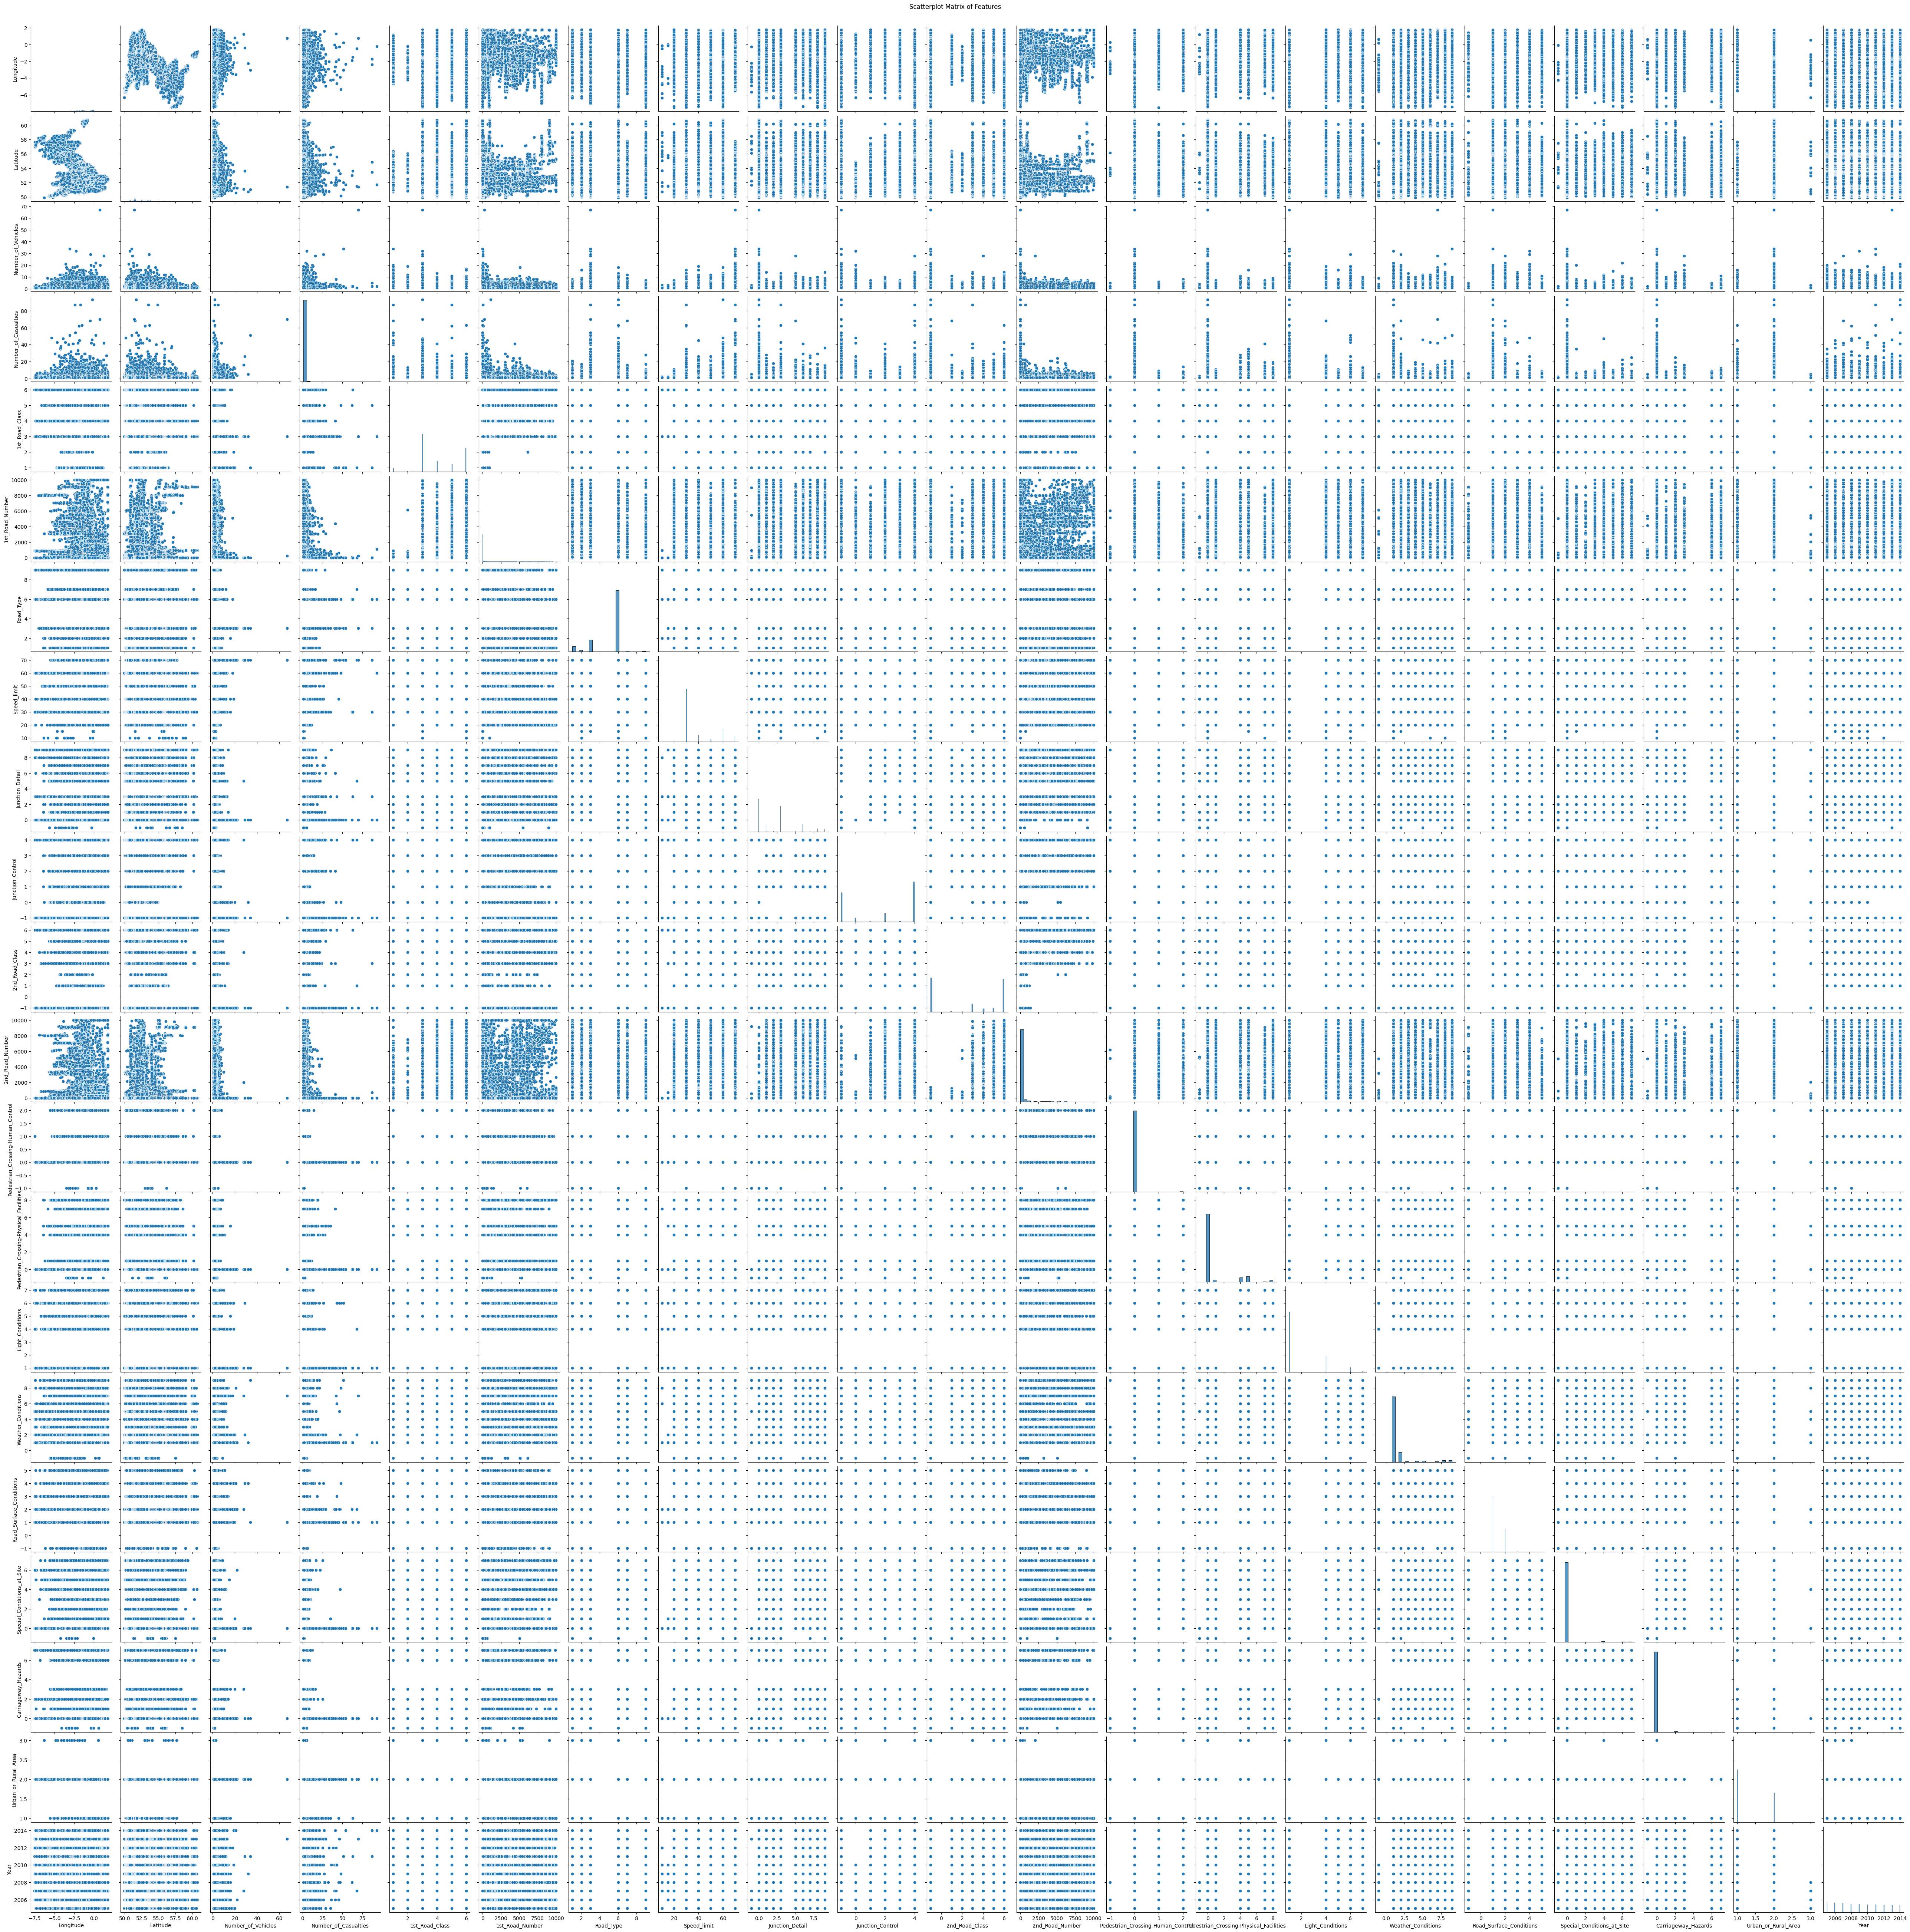

In [ ]:
# Scatter Plot Matrix 
sns.pairplot(accidents)
plt.suptitle('Scatterplot Matrix of Features', y = 1)
plt.show()

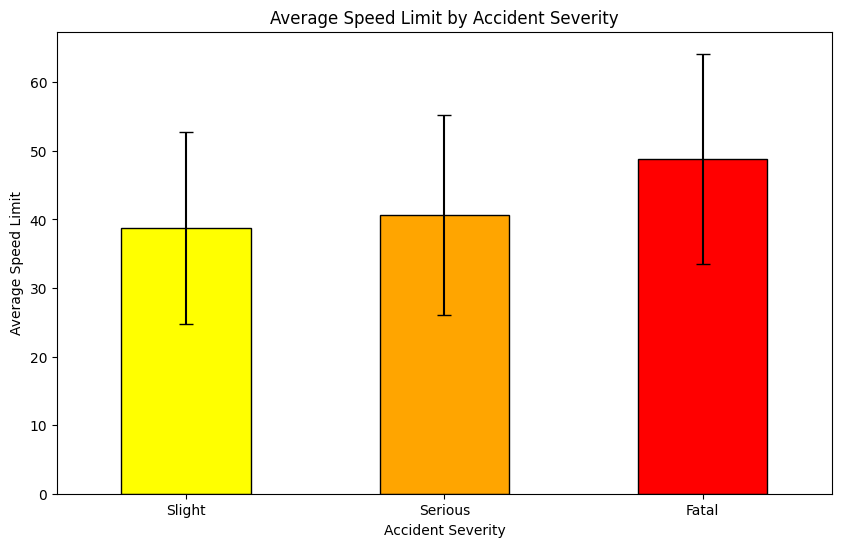

In [263]:
# Calculate average and standard deviation of speed limit by accident severity
average_speed_by_severity = accidents.groupby('Accident_Severity')['Speed_limit'].mean()
std_speed_by_severity = accidents.groupby('Accident_Severity')['Speed_limit'].std()

# Define custom order for the bars
custom_order = ['Slight', 'Serious', 'Fatal']

# Reorder the series
average_speed_by_severity = average_speed_by_severity.reindex(custom_order)
std_speed_by_severity = std_speed_by_severity.reindex(custom_order)

# Define colors for each severity level
colors = ['yellow', 'orange', 'red']


plt.figure(figsize=(10, 6))
average_speed_by_severity.plot(kind='bar', yerr=std_speed_by_severity, capsize=5, color=colors, edgecolor='black')
plt.title('Average Speed Limit by Accident Severity')
plt.xlabel('Accident Severity')
plt.ylabel('Average Speed Limit')
plt.xticks(rotation=0)
plt.show()


In [264]:
light_condition = pd.Series(metadata['Light Conditions']['label'].values, index=metadata['Light Conditions']['code']).to_dict()
accidents['Light_Conditions'] = accidents['Light_Conditions'].map(light_condition)

In [265]:
accidents["Light_Conditions"].value_counts()

Light_Conditions
Daylight                       1201696
Darkness - lights lit           322137
Darkness - no lighting           91670
Darkness - lighting unknown      17388
Darkness - lights unlit           7462
Name: count, dtype: int64

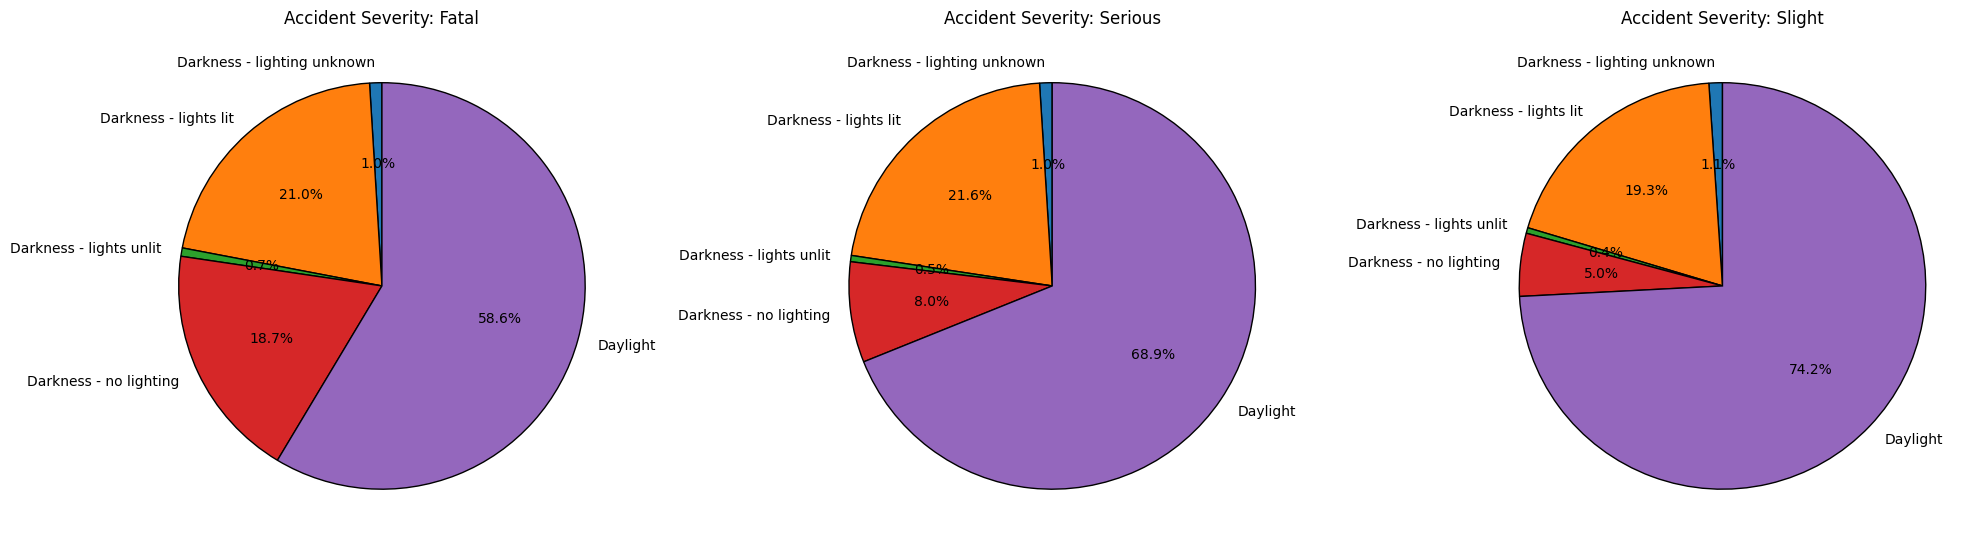

In [266]:
light_severity_counts = accidents.groupby(['Light_Conditions', 'Accident_Severity']).size().unstack(fill_value=0)
light_conditions = light_severity_counts.index.tolist()
accident_severities = light_severity_counts.columns.tolist()

fig, axes = plt.subplots(1, len(accident_severities), figsize=(20, 10))

for i, severity in enumerate(accident_severities):
    data = light_severity_counts[severity]
    axes[i].pie(data, labels=data.index, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
    axes[i].set_title(f'Accident Severity: {severity}')

plt.tight_layout()
plt.show()

In [267]:
weather_conditions = pd.Series(metadata['Weather']['label'].values, index=metadata['Weather']['code']).to_dict()
accidents['Weather_Conditions'] = accidents['Weather_Conditions'].map(weather_conditions)

In [197]:
weather_severity_counts = accidents.groupby(['Weather_Conditions', 'Accident_Severity']).size().unstack(fill_value=0)

weather_conditions = weather_severity_counts.index.tolist()
accident_severities = weather_severity_counts.columns.tolist()

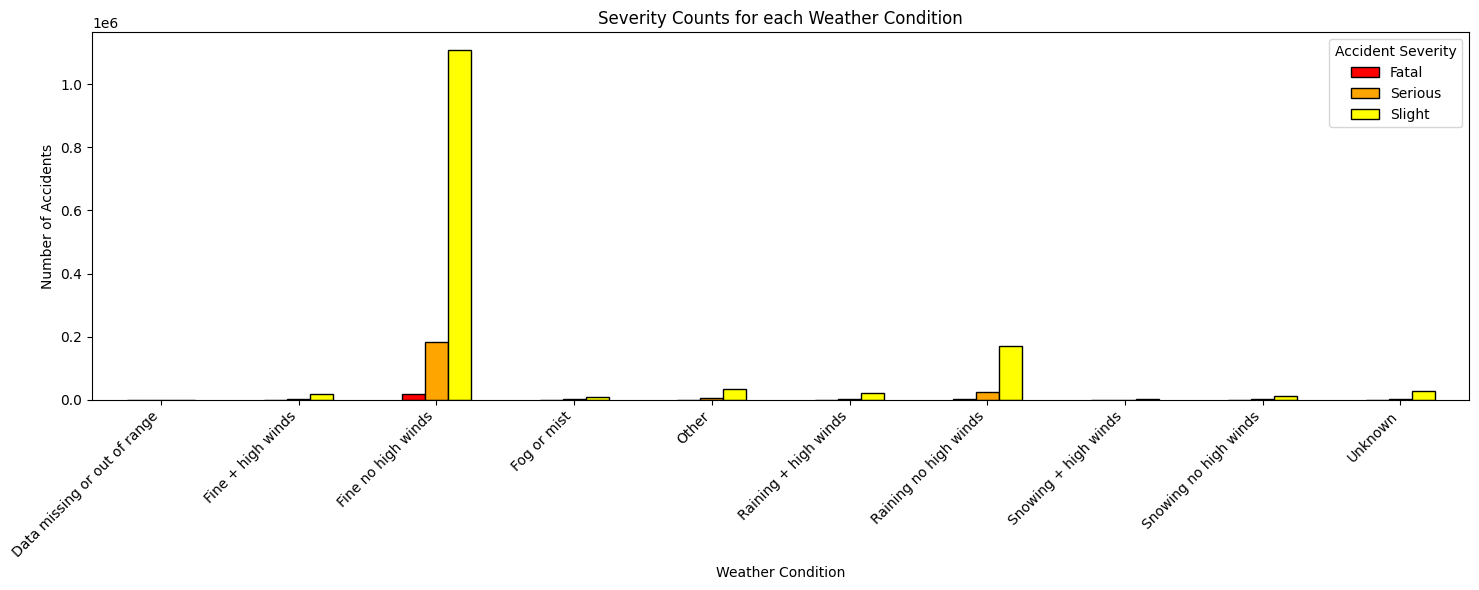

In [215]:
colors = ['red', 'orange', 'yellow']
weather_severity_counts.plot(kind='bar', figsize=(15, 6),color=colors, edgecolor='black')
plt.title('Severity Counts for each Weather Condition')
plt.xlabel('Weather Condition')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Accident Severity')
plt.tight_layout()
plt.show()

In [229]:
road_conditions = pd.Series(metadata['Road Surface']['label'].values, index=metadata['Road Surface']['code']).to_dict()
accidents['Road_Surface_Conditions'] = accidents['Road_Surface_Conditions'].map(road_conditions)
road_severity_counts = accidents.groupby(['Road_Surface_Conditions', 'Accident_Severity']).size().unstack(fill_value=0)

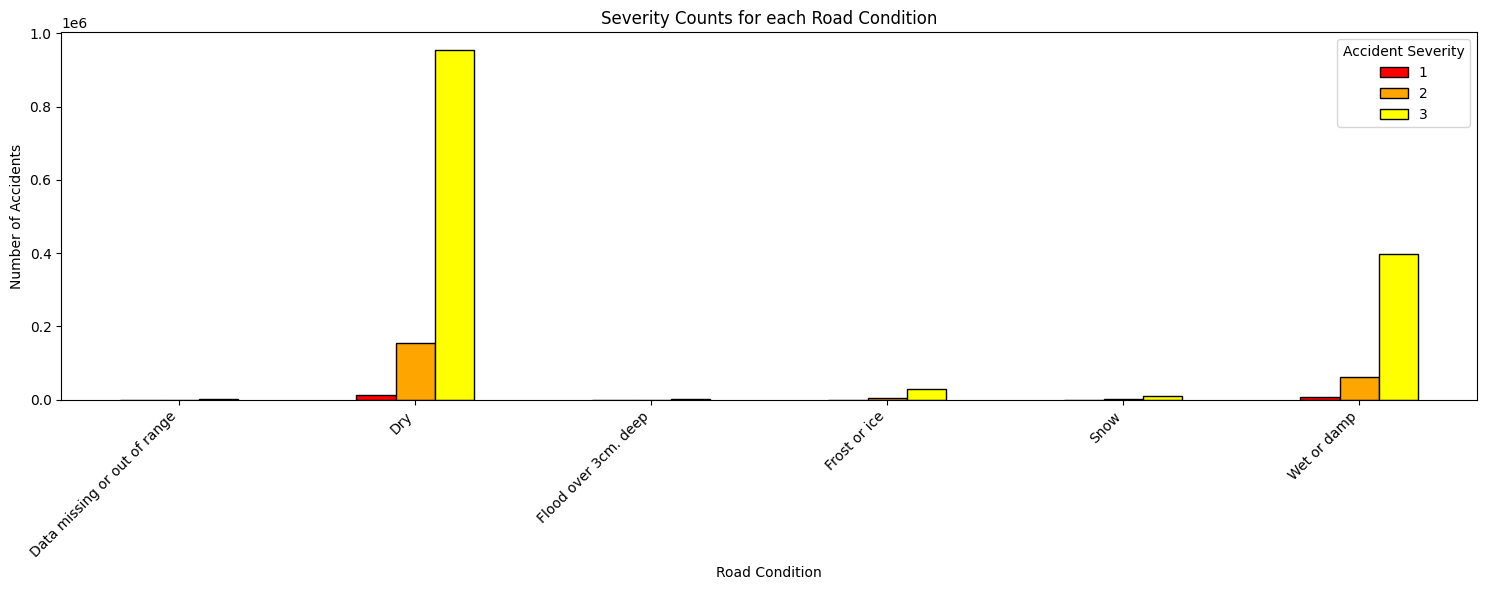

In [231]:
colors = ['red', 'orange', 'yellow']
road_severity_counts.plot(kind='bar', figsize=(15, 6),color=colors, edgecolor='black')
plt.title('Severity Counts for each Road Condition')
plt.xlabel('Road Condition')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Accident Severity')
plt.tight_layout()
plt.show()

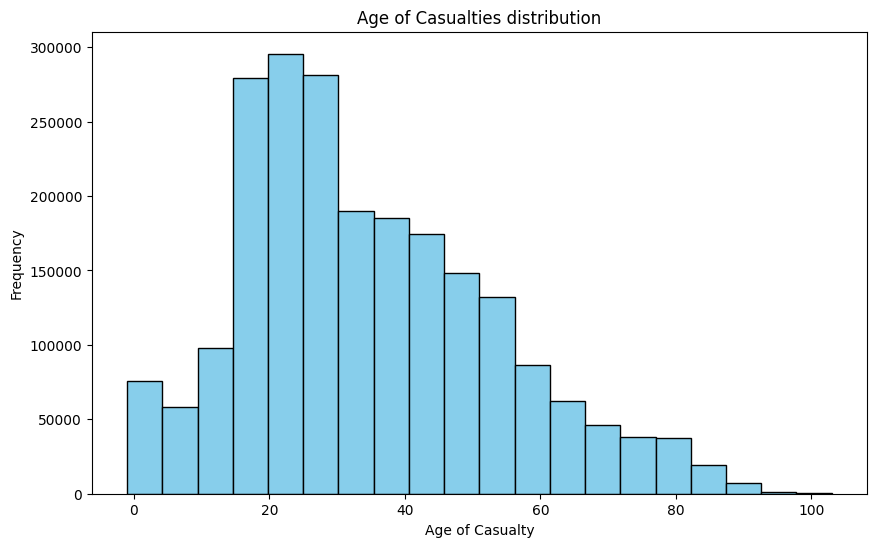

In [129]:
plt.figure(figsize=(10, 6))
plt.hist(casualties['Age_of_Casualty'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Age of Casualty')
plt.ylabel('Frequency')
plt.title('Age of Casualties distribution')
plt.show()

In [ ]:
merged_df = pd.merge(vehicles, accidents, on='Accident_Index', how='left')

average_age_by_severity = merged_df.groupby('Accident_Severity')['Age_of_Vehicle'].mean()

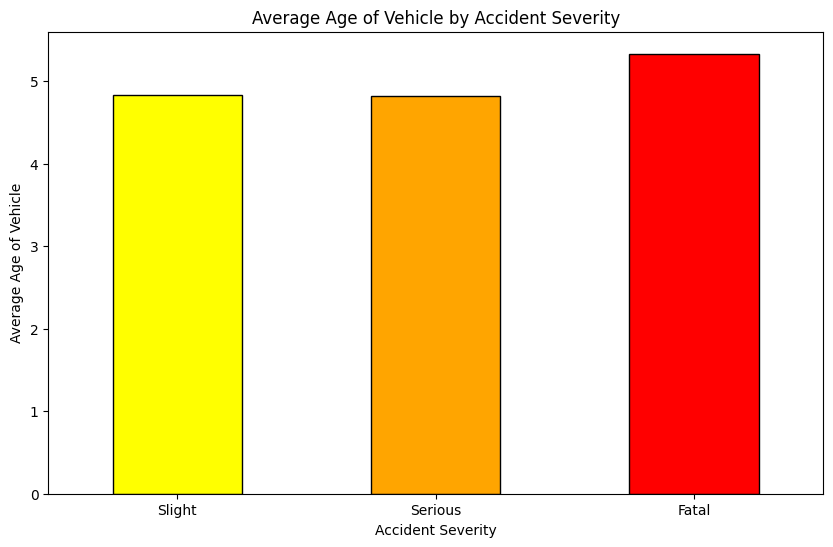

In [200]:
# Define custom order for the bars
custom_order = ['Slight', 'Serious', 'Fatal']
# Define colors for each severity level
colors = ['yellow', 'orange', 'red']
# Reorder the series based on the custom order
average_age_by_severity = average_age_by_severity.reindex(custom_order)

plt.figure(figsize=(10, 6))
average_age_by_severity.plot(kind='bar', color=colors, edgecolor='black')
plt.title('Average Age of Vehicle by Accident Severity')
plt.xlabel('Accident Severity')
plt.ylabel('Average Age of Vehicle')
plt.xticks(rotation=0)
plt.show()
# We don't need to include this one

In [201]:
average_engine_capacity_by_severity = merged_df.groupby('Accident_Severity')['Engine_Capacity_(CC)'].mean()

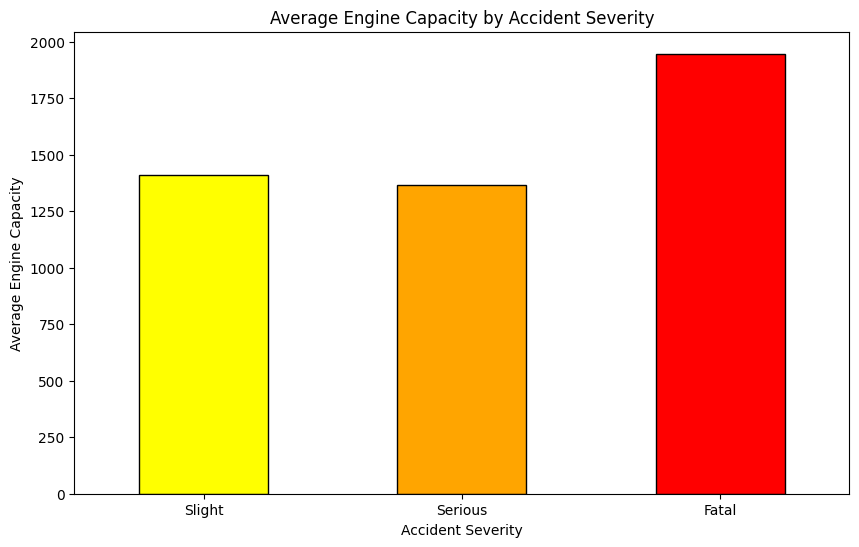

In [204]:
plt.figure(figsize=(10, 6))
# Define custom order for the bars
custom_order = ['Slight', 'Serious', 'Fatal']
# Define colors for each severity level
colors = ['yellow', 'orange', 'red']
# Reorder the series based on the custom order
average_engine_capacity_by_severity = average_engine_capacity_by_severity.reindex(custom_order)
average_engine_capacity_by_severity.plot(kind='bar', color=colors, edgecolor='black')
plt.title('Average Engine Capacity by Accident Severity')
plt.xlabel('Accident Severity')
plt.ylabel('Average Engine Capacity')
plt.xticks(rotation=0)
plt.show()

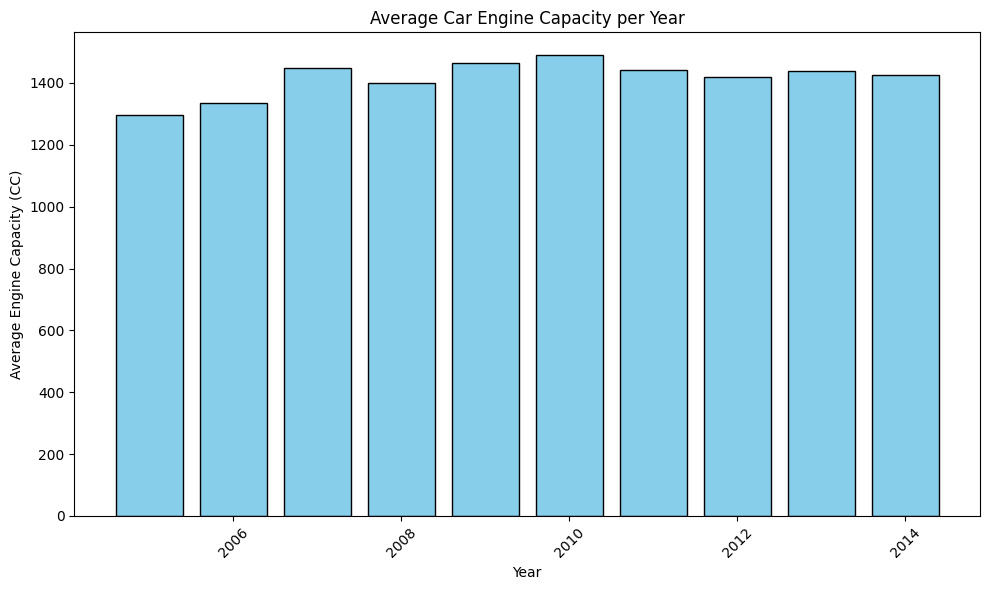

In [99]:
merged_df['Date'] = pd.to_datetime(merged_df['Date'], format="%d/%m/%Y")
merged_df['Year'] = merged_df['Date'].dt.year
average_engine_capacity_per_year = merged_df.groupby('Year')['Engine_Capacity_(CC)'].mean()

plt.figure(figsize=(10, 6))
plt.bar(average_engine_capacity_per_year.index, average_engine_capacity_per_year.values, color='skyblue', edgecolor='black')
plt.xlabel('Year')
plt.ylabel('Average Engine Capacity (CC)')
plt.title('Average Car Engine Capacity per Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# We don't need to include this one

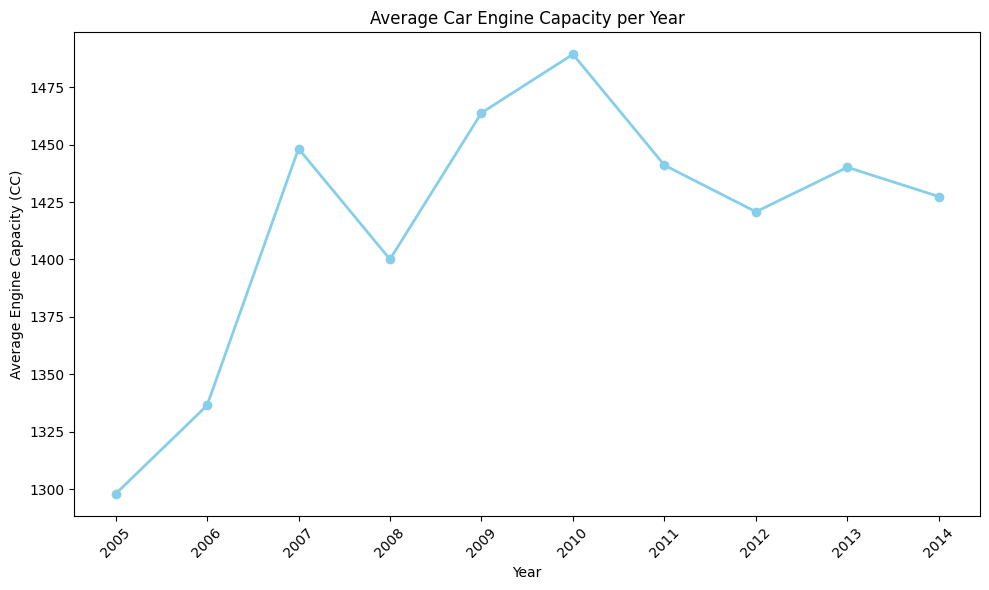

In [ ]:
# Convert Date to datetime and extract Year
merged_df['Date'] = pd.to_datetime(merged_df['Date'], format="%d/%m/%Y")
merged_df['Year'] = merged_df['Date'].dt.year

# Calculate average engine capacity per year
average_engine_capacity_per_year = merged_df.groupby('Year')['Engine_Capacity_(CC)'].mean()

# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(average_engine_capacity_per_year.index, average_engine_capacity_per_year.values, marker='o', color='skyblue', linestyle='-', linewidth=2)
plt.xlabel('Year')
plt.ylabel('Average Engine Capacity (CC)')
plt.title('Average Car Engine Capacity per Year')
plt.xticks(ticks=average_engine_capacity_per_year.index, labels=average_engine_capacity_per_year.index, rotation=45)
plt.tight_layout()
plt.show()

In [206]:
average_age_by_severity = merged_df.groupby('Accident_Severity')['Age_of_Driver'].mean()

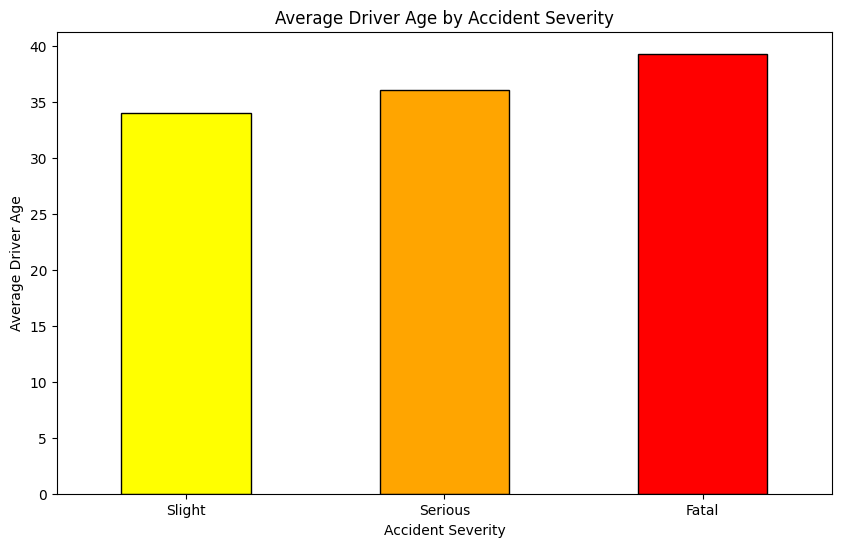

In [208]:
plt.figure(figsize=(10, 6))
# Define custom order for the bars
custom_order = ['Slight', 'Serious', 'Fatal']
# Define colors for each severity level
colors = ['yellow', 'orange', 'red']
# Reorder the series based on the custom order
average_age_by_severity = average_age_by_severity.reindex(custom_order)
average_age_by_severity.plot(kind='bar', color=colors, edgecolor='black')
plt.title('Average Driver Age by Accident Severity')
plt.xlabel('Accident Severity')
plt.ylabel('Average Driver Age')
plt.xticks(rotation=0)
plt.show()

In [101]:
sampled_accident = accidents.sample(n=100000, random_state=42)
map_center = folium.Map(location=[sampled_accident['Latitude'].mean(), sampled_accident['Longitude'].mean()], zoom_start=6)

heat_data = [[row['Latitude'], row['Longitude']] for index, row in sampled_accident.iterrows()]

HeatMap(heat_data, radius=15, blur=20, max_zoom=13).add_to(map_center)
map_center

In [13]:
# One hot encoding for categorical variables
def encoding(df, feature_list):
  for feature in feature_list:
    onehot = OneHotEncoder(sparse_output=False, drop='first')
    category_encod = onehot.fit_transform(df[[feature]])
    encoded_df = pd.DataFrame(category_encod, columns=onehot.get_feature_names_out([feature]), index=df.index)

    df = pd.concat([df, encoded_df], axis=1)
    df.drop([feature], axis=1, inplace=True)

  return df

In [14]:
# Get labels for categorical variable and get them read
road = pd.Series(metadata['Road Type']['label'].values, index=metadata['Road Type']['code']).to_dict()
accidents['Road_Type'] = accidents['Road_Type'].map(road)
urban = pd.Series(metadata['Urban Rural']['label'].values, index=metadata['Urban Rural']['code']).to_dict()
accidents['Urban_or_Rural_Area'] = accidents['Urban_or_Rural_Area'].map(urban)

In [15]:
# Choosing the features that most contribute to the severity of an accident
X = accidents[['Road_Surface_Conditions', 'Weather_Conditions', 'Day_of_Week', 'Road_Type', 'Light_Conditions', 'Speed_limit', 'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident']]
y = accidents['Accident_Severity']
# encode the features chosen
X = encoding(X, ['Road_Surface_Conditions', 'Weather_Conditions', 'Day_of_Week', 'Road_Type', 'Light_Conditions', 'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident'])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

rf = RandomForestClassifier(random_state=42)
# train model
rf.fit(X_train, y_train)
# predict labels
y_pred = rf.predict(X_test)

In [ ]:
# Evaluate training F1
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
train_f1 = f1_score(y_train, y_train_pred, average='weighted')
print(f"Training F1 random forest: {train_f1:.4f}")

Training F1 random forest: 0.7861


In [ ]:
# Evaluate test F1
y_test_pred = rf.predict(X_test)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
print(f"Test F1 random forest: {test_f1:.4f}")

Test F1 random forest: 0.7833


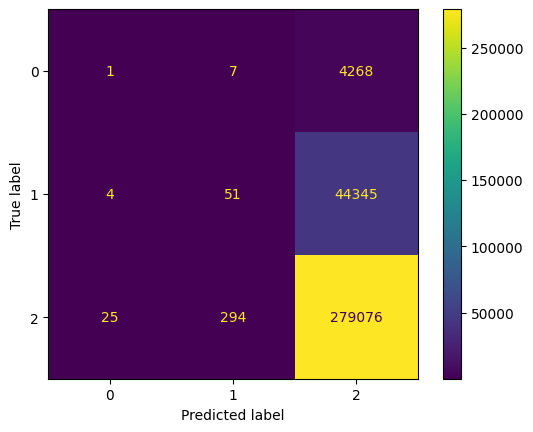

In [23]:
# Creates confusion matrix diagram
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()